In [38]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [39]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [40]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [41]:
df = pd.read_csv(INPUT_FILE)

In [42]:
sl = df.loc[df.country_name=='Uganda']

In [43]:
sl.shape

(113558, 40)

In [44]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [45]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [46]:
#we can't have any null target values
len(df2[df2.status_binary.isna()==True])


4

In [47]:
#eliminate null target values
df2 = df2[pd.notnull(df['status_binary'])]

In [48]:
#check
len(df2[df2.status_binary.isna()==True])


0

In [49]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [50]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [22]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
print('model fit for inner CV for Sierra Leone')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Sierra Leone
Shape of input params=  (68132, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Best grid score on inner CV 0.841763048201
Accuracy for inner nested_cv model : 0.8452
AUC Score (test) for inner_nested cv_model: 0.842539
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [15]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
#print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Accuracy for outer nested_cv model on training data: 0.8765
AUC Score (Train) for outer nested_cv model: 0.923664
AUC Score (Test) for outer nested_cv model: 0.842539
AUC Score (Holdout) for outer nested_cv model: 0.851344
Accuracy for outer nested_cv model on holdout data: 0.8461


In [26]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [27]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.85014984  0.84695036  0.85144637  0.85206958  0.85015851]
Accuracy full-data : 0.8468
AUC Score full-data: 0.850130


(array([ 0.,  0.,  0., ...,  0.,  1.,  0.]), array([[ 0.61308217,  0.38691786],
        [ 0.71306306,  0.28693694],
        [ 0.74245048,  0.25754949],
        ..., 
        [ 0.79523325,  0.20476678],
        [ 0.14188886,  0.85811114],
        [ 0.58353257,  0.4164674 ]], dtype=float32))

In [26]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [27]:
save_model(model_outer, "Uganda Holdout using TVH")

saved as Uganda Holdout using TVH_pickle.sav


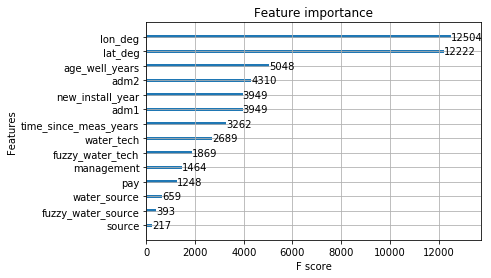

In [30]:
xgb.plot_importance(model_outer, )

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

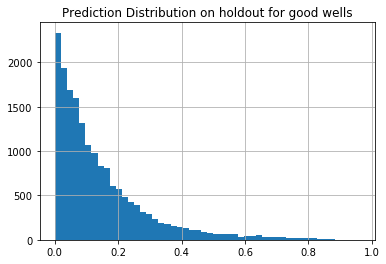

In [31]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


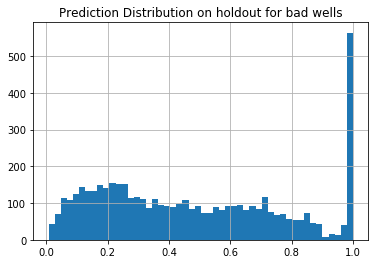

In [32]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([ 0.47152223,  0.90239599,  1.11376802,  1.24384312,  1.45521515,
         1.31701036,  1.55277147,  1.35765883,  1.47147454,  1.61780902,
         1.30888067,  1.17067588,  1.05686017,  1.0162117 ,  1.0162117 ,
         0.94304446,  0.91052568,  1.04873047,  0.93491476,  0.93491476,
         0.77232089,  0.7560615 ,  0.83735844,  0.94304446,  0.92678507,
         0.84548813,  0.93491476,  0.90239599,  1.10563833,  0.77232089,
         0.61785671,  0.65850518,  0.52030039,  0.69915365,  0.57720824,
         0.41461437,  0.10568602,  0.13820479,  0.29266897,  4.69083319]),
 array([ 0.00776089,  0.03254048,  0.05732006,  0.08209965,  0.10687924,
         0.13165882,  0.15643841,  0.181218  ,  0.20599758,  0.23077717,
         0.25555675,  0.28033634,  0.30511593,  0.32989551,  0.3546751 ,
         0.37945469,  0.40423427,  0.42901386,  0.45379344,  0.47857303,
         0.50335262,  0.5281322 ,  0.55291179,  0.57769138,  0.60247096,
         0.62725055,  0.65203013,  0.67680972,  0

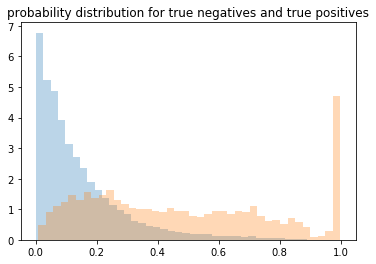

In [33]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### This is a much better spread than our small holdout last time. I wonder if this is from the target leakage from the repeat measurements? Could that even be target leakage?

In [28]:
def evaluate_prediction_thresholds(y_true, y_pred_probs, recall_val):
    import numpy as np
    d = dict()
    for i in np.linspace(0,0.5, num=20):
        best = 0
        test = np.where(y_pred_probs > i, 1,0)
        recall = metrics.recall_score(y_true, test)
        precision = metrics.precision_score(y_true, test)
        f_score = metrics.f1_score(y_true, test, average='binary')
        d[i]=recall, precision, f_score

    frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
    frame.columns=(['recall','precision', 'f1_score'])
    frame = frame[frame.recall>recall_val]
    return frame

In [29]:
evaluate_prediction_thresholds(y_test, dtest_predprob, .7)

,recall,precision,f1_score
0.000000,1.000000,0.218572,0.358735
0.026316,0.991136,0.250229,0.399578
0.052632,0.967768,0.280689,0.435165
0.078947,0.934327,0.313400,0.469362
0.105263,0.894641,0.346142,0.499157
0.131579,0.860193,0.378916,0.526089
0.157895,0.819702,0.411052,0.547534
0.184211,0.779009,0.442094,0.564073
0.210526,0.737510,0.475393,0.578129


In [31]:
evaluate_prediction_thresholds(y_holdout, dholdout_predprob, .7)

,recall,precision,f1_score
0.000000,1.000000,0.218572,0.358735
0.026316,0.992143,0.251263,0.400977
0.052632,0.971394,0.282815,0.438085
0.078947,0.941579,0.316860,0.474157
0.105263,0.908743,0.350016,0.505378
0.131579,0.871676,0.381873,0.531083
0.157895,0.837832,0.414946,0.555014
0.184211,0.797341,0.449875,0.575207
0.210526,0.756648,0.482404,0.589176
0.236842,0.720588,0.513642,0.599765


## Modeling Decision: Threshold of 0.236842 gives a recall > 0.72 and a precision > 0.51 on both test and holdout. Will use as threshold. Not great but want to have at least a 50% chance of investigating a real bad well (prioritization) and balanced with catching as many as possible (recall).

### Create predictions for the out years based on data. Need to update time since measurement in X_Today.  Mistakenly didn't increase it's time

In [51]:
model_outer=pickle.load(open('Uganda Holdout using TVH_pickle.sav', 'rb'))

In [53]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
#X_today['time_since_meas_years'] = X_today.time_since_meas_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
38495,34,21,12,12,121,267,165,1.33007,31.3906,86,279.6,5.6,10,0


In [54]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
#X_1year['time_since_meas_years']=X_1year.time_since_meas_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
#X_3year['time_since_meas_years']=X_3year.time_since_meas_years + 2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4
#X_5year['time_since_meas_years']=X_5year.time_since_meas_years + 4

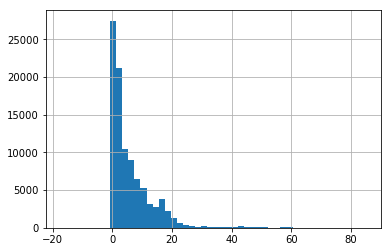

In [55]:
X[X.age_well_years!= 274].age_well_years.hist(bins=50) #no missing values

In [56]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today[['age_well_years', 'time_since_meas_years']][:1])
print(X_1year[['age_well_years', 'time_since_meas_years']][:1])
print(X_3year[['age_well_years', 'time_since_meas_years']][:1])
print(X_5year[['age_well_years', 'time_since_meas_years']][:1])

       age_well_years  time_since_meas_years
38495           274.0                    5.6
       age_well_years  time_since_meas_years
38495           279.6                    5.6
       age_well_years  time_since_meas_years
38495           280.6                    5.6
       age_well_years  time_since_meas_years
38495           282.6                    5.6
       age_well_years  time_since_meas_years
38495           284.6                    5.6


# Get Predictions for Today, 1, 3 and 5 years out

In [57]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [60]:
# append them to the original df
#erroring, since we had to drop a few NaN rows
sl = df2
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [43]:
#OLD WAY WITHOUT CORRECT TIME SINCE MEASUREMENT
#sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,113554.000000,113554.000000,113554.000000,113554.000000,113554.000000
mean,0.218574,0.142426,0.110837,0.047017,0.063371
std,0.413281,0.349488,0.313932,0.211677,0.243630
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
#new results with updated time since measurement
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,113554.000000,113554.000000,113554.000000,113554.000000,113554.000000
mean,0.218574,0.142426,0.144231,0.145983,0.146609
std,0.413281,0.349488,0.351325,0.353091,0.353717
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# 0.5 threshold won't do, setting a modeling decision of > 70% recall and > 50% precision for our prediction threshold. Threshold = 0.236842

In [62]:
threshold = 0.236842
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [43]:
#old way WITHOUT updated predictions
coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,113554.000000,113554.000000,113554.000000,113554.000000,113554.000000
mean,0.218574,0.387798,0.430958,0.437343,0.441068
std,0.413281,0.487250,0.495212,0.496061,0.496517
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
#drop missing target columns
ug = df.loc[df.country_name=='Uganda']
ug = ug[pd.notnull(ug['status_binary'])]
coerced2 = append_outyear_predictions(ug, 0.236842, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [64]:
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,113554.000000,113554.000000,113554.000000,113554.000000,113554.000000
mean,0.218574,0.387798,0.395680,0.401465,0.405745
std,0.413281,0.487250,0.488998,0.490197,0.491038
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
coerced2[coerced2.status_binary==0][(coerced2.today_preds<coerced2.one_year_preds)].shape

(895, 48)

In [66]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.86      0.96      0.91     17747
        1.0       0.76      0.44      0.55      4964

avg / total       0.84      0.85      0.83     22711



In [67]:
# see what precision/ recall is on holdout using our new threshold
threshold = 0.236842
holdout_preds = np.where(dholdout_predprob>threshold, 1, 0)
print(metrics.classification_report(y_holdout, holdout_preds))
print(metrics.confusion_matrix(y_holdout, holdout_preds))

             precision    recall  f1-score   support

        0.0       0.91      0.81      0.86     17747
        1.0       0.51      0.72      0.60      4964

avg / total       0.82      0.79      0.80     22711

[[14360  3387]
 [ 1387  3577]]


# Using 22,711 wells as holdout (unseen data), we were able to catch 72% of them (3577/4964) while keeping about a 50% likelihood of finding one. 

In [72]:
sl.to_csv('Uganda_w_outyear_predictions.csv')

In [73]:
pd.read_csv('Uganda_w_outyear_predictions.csv').shape

(113554, 24)

In [48]:
coerced.to_csv('Uganda_w_outyear_predictions_coerced.csv')

In [68]:
coerced2.to_csv('Uganda_w_outyear_predictions_coerced_correct_time2.csv')

In [51]:
features

['water_source',
 'water_tech',
 'management',
 'source',
 'adm1',
 'adm2',
 'pay',
 'lat_deg',
 'lon_deg',
 'new_install_year',
 'age_well_years',
 'time_since_meas_years',
 'fuzzy_water_source',
 'fuzzy_water_tech',
 'status_binary']

In [1]:

def top_feat_table(df,feat):
    """
    returns functioning and non-functioning wells by the most important
    (or any) feature
    args: un-label encoded data frame; top feature (string)
    returns: dataframe
    """
    #shows what of the top features failed in the training data
    gp = df.groupby([feat, 'status_binary']).size().unstack()
    gp['percentage_broken'] = round(gp[1]/gp.sum(axis=1)*100,2)
    gp.reset_index(inplace=True)
    gp.rename(columns={0:'# functioning', 1:'# not functioning'},index={'status_binary':'index'},  inplace=True)
    gp.sort_values(by='# not functioning', ascending =False, inplace=True)
    gp.rename_axis('index', axis='columns').fillna(0, inplace=True)
    return gp

In [10]:
top_feat_table(sl, 'installer')

status_binary,installer,# functioning,# not functioning,percentage_broken
65,__MISSING__,87305.0,24197.0,21.70
64,World Vision,486.0,109.0,18.32
84,central_govt,61.0,85.0,58.22
164,local_govt,76.0,79.0,50.97
77,busoga_trust,81.0,22.0,21.36
173,ministry_of_ed,5.0,22.0,81.48
187,nusaf,48.0,21.0,30.43
163,local community,3.0,16.0,84.21
172,masindi_dlg,45.0,13.0,22.41
272,vrm,19.0,11.0,36.67


# try with removing the actual water tech and source since they are so noisy, and just keep the fuzzy matched features for training

In [59]:
features2 = ['management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

In [62]:
pred_cols = features2

#create a copy of the dataframe to label encode
df3=df2[pred_cols]

In [65]:
X = df3[df3.columns[:-1]] 
Y= df3.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [66]:
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [67]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[1000, 2500]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [1000, 2500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [68]:
print('model fit for inner CV for Sierra Leone')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Sierra Leone
Shape of input params=  (68132, 12)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000}
Best grid score on inner CV 0.841674983855
Accuracy for inner nested_cv model : 0.8451
AUC Score (test) for inner_nested cv_model: 0.841715
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [69]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Number of trees determined by early stopping and in final model 1000
Accuracy for outer nested_cv model on training data: 0.878
AUC Score (Train) for outer nested_cv model: 0.924759
AUC Score (Test) for outer nested_cv model: 0.841715
AUC Score (Holdout) for outer nested_cv model: 0.850328
Accuracy for outer nested_cv model on holdout data: 0.8455


In [70]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.84931713  0.84788596  0.84916414  0.8529253   0.84952233]
Accuracy full-data : 0.8466
AUC Score full-data: 0.849739


(array([ 1.,  0.,  0., ...,  0.,  1.,  0.]), array([[ 0.49334359,  0.50665641],
        [ 0.67738378,  0.32261625],
        [ 0.7006554 ,  0.2993446 ],
        ..., 
        [ 0.81501555,  0.18498443],
        [ 0.1369198 ,  0.8630802 ],
        [ 0.63395309,  0.36604688]], dtype=float32))

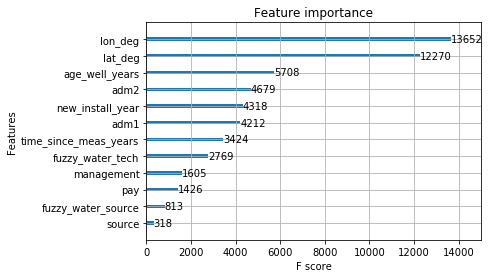

In [71]:
xgb.plot_importance(model_outer)

In [77]:
save_model(model_outer, 'Uganda_Holdout_TVH_only_Fuzzy_Matched')

saved as Uganda_Holdout_TVH_only_Fuzzy_Matched_pickle.sav


In [78]:
sl.groupby('adm2').size()

adm2
AGAGO                  650
AMURIA                 407
ARINGA                 690
ARUU                   366
ASWA                   419
AYIVU                  825
Abim                    59
Abim T/C                42
Alerek                  27
Amudat                  38
Amudat T/C              13
BAMUNANIKA             410
BBAALE                 835
BOKORA                 344
BUBULO                 839
BUDADIRI               917
BUDAKA                 507
BUDAMA                 514
BUDIOPE                445
BUFUMBIRA              849
BUGABULA               630
BUGAHYA                850
BUGHENDERA             338
BUGWERI                331
BUHAGUZI               708
BUIKWE                 929
BUJUMBA                144
BUKANGA               1081
BUKHOOLI               328
BUKOMANSIMBI           684
BUKONZO               1879
BUKOOLI                737
BUKOTO                1712
BULAMBULI              625
BULAMOGI               386
BULIISA                287
BUNGOKHO              1